In [2]:
import sys
from pathlib import Path
sys.path.insert(0,str(Path.cwd().parent))
from package import *
from datetime import datetime
from package.DandjooId import DandjooId
from shapely.geometry import MultiPolygon
import geopandas as gpd
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
import socket
from dateutil import parser
from datetime import datetime
from pyproj import Proj, transform
pd.set_option('display.max_rows', None, 'display.max_columns', None, 'display.width', None, 'display.max_colwidth',None)

QUALITY ASSURANCE CHECK ON THE VERTEBRATES FOREST DATA

Step 1) User specifies path to file in blob store container, file read as dataframe.

In [3]:
# define containers: 010-recieved, 015-recieved, record deltas
creds: pd.DataFrame = pd.read_csv('credential.csv',dtype=str, index_col='item')
cred: str = creds.loc['cred','value']

a10_recieved: str = creds.loc['10_recieved','value']
a15_extracted: str = creds.loc['15_extracted','value']
a20_tabular: str = creds.loc['20_tabular','value']
a25_preprocessed: str = creds.loc['25_preprocessed','value']
a30_ingestion: str = creds.loc['30_ingestion','value']

a10_recieved: ContainerClient = ContainerClient.from_container_url(a10_recieved, cred)
a15_extracted: ContainerClient = ContainerClient.from_container_url(a15_extracted, cred)
a20_tabular: ContainerClient = ContainerClient.from_container_url(a20_tabular, cred)
a25_preprocessed: ContainerClient = ContainerClient.from_container_url(a25_preprocessed, cred)
a30_ingestion: ContainerClient = ContainerClient.from_container_url(a30_ingestion, cred)

# Define file paramaters - the path of the file in the blobstore.
infile: Path = Path('AquaticProjects/ForestCheck Data/Vertebrates/Vertebrates Master File.xlsx')
parent: Path = infile.parent
filename: str = infile.name.removesuffix(infile.suffix).lower().replace('.','')
filename = '_'.join(filename.split())
targetp: Path = parent / f'{filename}.csv'
partdir: Path = parent / filename
logpath: Path = partdir / f'{filename}_log.csv'
invpath: Path = partdir / f'{filename}_invalid.csv'

eventlog: pd.DataFrame = pd.DataFrame(columns=['event_id','datetime','user','description'])
message, af = read_df(a15_extracted, infile)
af.head()

,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,TRAP DAY,DAY,MONTH,YEAR.1,PERSONNEL,TRAP TYPE,STATUS,RETRAP,TRAP POINT,SPECIES CODE,COMMON NAME,SCIENTIFIC NAME,WEIGHT (g),TAG # 1,TAG # 2,SEX,BREEDING CONDITION,WAM SPECIMEN,COMMENTS,PLOT NO,GRID PREFIX,LOCATION,TREATMENT,FIRE TREATMENT,GDA94 EASTING Central Peg W2.3,GDA94 NORTHING Central Peg W2.3,GDA94 EASTING Trap Location,GDA94 NORTHING Trap Location
0,5326,SV1-1,1,2001,SUMMER,1,11,12,2001,Chris VELLIOS and Bob SMITH,No captures,No captures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nil return,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,NaN,NaN
1,5327,SV1-2,2,2001,SUMMER,2,12,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P2-1,HEMPER,Lowland Earless Skink,Hemiergis peronii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437900.006,6229232.54402
2,5328,SV1-3,3,2001,SUMMER,3,13,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P3-2,HEMPER,Lowland Earless Skink,Hemiergis peronii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437930.77300000004,6229237.08702
3,5329,SV1-4,4,2001,SUMMER,3,13,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P3-2,CHRMAR,Marbled Gecko,Christinus marmoratus,NaN,NaN,NaN,NaN,NaN,NaN,Brown black spots - white pink,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437930.77300000004,6229237.08702
4,5330,SV1-5,5,2001,SUMMER,3,13,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P3-5,HEMPER,Lowland Earless Skink,Hemiergis peronii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437973.20300000004,6229194.87702


Logged error while reading file

In [4]:
logevent(description=f'errors when reading file "{str(infile)}" : {message}',
         user=socket.gethostname(),
         eventlog=eventlog)

,event_id,datetime,user,description
0,2024JRJcI5329b02,2024-09-17T09:28:08.340655,Charles,"errors when reading file ""AquaticProjects/ForestCheck Data/Vertebrates/Vertebrates Master File.xlsx"" : N/A"


Renaming some complex column names into a simple name

In [5]:
def rename_columns(df, columns_dict):
    """
    Rename columns in a Dataframe.

    Parameters:
    df(pd.DataFrame): The DataFrame whose columns need to be renamed.
    columns_dict(dict): A dictionary where keys are old column names and values are new column names.

    Returns:
    pd.DataFrame: DataFrame with renamed columns.
    """
    df.rename(columns=columns_dict, inplace=True)
    return df

# Renaming columns
new_columns = {'GDA94 EASTING Central Peg W2.3': 'GDA94 EASTING Central', 'GDA94 NORTHING Central Peg W2.3': 'GDA94 NORTHING Central'}
aff = rename_columns(af, new_columns)
aff.head()

,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,TRAP DAY,DAY,MONTH,YEAR.1,PERSONNEL,TRAP TYPE,STATUS,RETRAP,TRAP POINT,SPECIES CODE,COMMON NAME,SCIENTIFIC NAME,WEIGHT (g),TAG # 1,TAG # 2,SEX,BREEDING CONDITION,WAM SPECIMEN,COMMENTS,PLOT NO,GRID PREFIX,LOCATION,TREATMENT,FIRE TREATMENT,GDA94 EASTING Central,GDA94 NORTHING Central,GDA94 EASTING Trap Location,GDA94 NORTHING Trap Location
0,5326,SV1-1,1,2001,SUMMER,1,11,12,2001,Chris VELLIOS and Bob SMITH,No captures,No captures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nil return,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,NaN,NaN
1,5327,SV1-2,2,2001,SUMMER,2,12,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P2-1,HEMPER,Lowland Earless Skink,Hemiergis peronii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437900.006,6229232.54402
2,5328,SV1-3,3,2001,SUMMER,3,13,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P3-2,HEMPER,Lowland Earless Skink,Hemiergis peronii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437930.77300000004,6229237.08702
3,5329,SV1-4,4,2001,SUMMER,3,13,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P3-2,CHRMAR,Marbled Gecko,Christinus marmoratus,NaN,NaN,NaN,NaN,NaN,NaN,Brown black spots - white pink,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437930.77300000004,6229237.08702
4,5330,SV1-5,5,2001,SUMMER,3,13,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P3-5,HEMPER,Lowland Earless Skink,Hemiergis peronii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437973.20300000004,6229194.87702


Convert the location data ('GDA94 EASTING Central' and 'GDA94 NORTHING Central') to Longitude and Latitude

In [6]:
# Define projections using EPSG codes
gda94 = Proj('epsg:28350')  # GDA94 
wgs84 = Proj('epsg:4326')   # WGS84

# Function to convert coordinates
def convert_to_latlon(easting, northing):
    lat, lon = transform(gda94, wgs84, easting, northing)
    return lat, lon

# Apply conversion by calling the function
aff['Latitude'], aff['Longitude'] = zip(*aff.apply(lambda row: convert_to_latlon(row['GDA94 EASTING Central'], row['GDA94 NORTHING Central']), axis=1))

aff.head()

/tmp/ipykernel_880/1575176851.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lat, lon = transform(gda94, wgs84, easting, northing)


,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,TRAP DAY,DAY,MONTH,YEAR.1,PERSONNEL,TRAP TYPE,STATUS,RETRAP,TRAP POINT,SPECIES CODE,COMMON NAME,SCIENTIFIC NAME,WEIGHT (g),TAG # 1,TAG # 2,SEX,BREEDING CONDITION,WAM SPECIMEN,COMMENTS,PLOT NO,GRID PREFIX,LOCATION,TREATMENT,FIRE TREATMENT,GDA94 EASTING Central,GDA94 NORTHING Central,GDA94 EASTING Trap Location,GDA94 NORTHING Trap Location,Latitude,Longitude
0,5326,SV1-1,1,2001,SUMMER,1,11,12,2001,Chris VELLIOS and Bob SMITH,No captures,No captures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nil return,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,NaN,NaN,-34.076078,116.327252
1,5327,SV1-2,2,2001,SUMMER,2,12,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P2-1,HEMPER,Lowland Earless Skink,Hemiergis peronii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437900.006,6229232.54402,-34.076078,116.327252
2,5328,SV1-3,3,2001,SUMMER,3,13,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P3-2,HEMPER,Lowland Earless Skink,Hemiergis peronii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437930.77300000004,6229237.08702,-34.076078,116.327252
3,5329,SV1-4,4,2001,SUMMER,3,13,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P3-2,CHRMAR,Marbled Gecko,Christinus marmoratus,NaN,NaN,NaN,NaN,NaN,NaN,Brown black spots - white pink,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437930.77300000004,6229237.08702,-34.076078,116.327252
4,5330,SV1-5,5,2001,SUMMER,3,13,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P3-5,HEMPER,Lowland Earless Skink,Hemiergis peronii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437973.20300000004,6229194.87702,-34.076078,116.327252


Concartenate the 'YEAR', 'MONTH' and 'DAY' column in 'aff' DataFrame to a new column called 'DATE'

In [7]:
# Create a new variable for the aff dataframe above
af1: pd.DataFrame = aff.copy(deep=True)

# Ensure column names are correct
af1.columns = af1.columns.str.strip()

# Drop any duplicate column (ie select only columns that are not duplicate(~))
af1 = af1.loc[:, ~af1.columns.duplicated()]

# Create 'DATE' column, and ensure that invalid 'DATES' are converted to NAN (Using the function, errors='coerce')
af1['DATE'] = pd.to_datetime(af1[['YEAR','MONTH','DAY']], errors='coerce')

# Drop rows where 'DATE' is NAN or Not a time
#af1 = af1.dropna(subset=['DATE'])

af1.head()


,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,TRAP DAY,DAY,MONTH,YEAR.1,PERSONNEL,TRAP TYPE,STATUS,RETRAP,TRAP POINT,SPECIES CODE,COMMON NAME,SCIENTIFIC NAME,WEIGHT (g),TAG # 1,TAG # 2,SEX,BREEDING CONDITION,WAM SPECIMEN,COMMENTS,PLOT NO,GRID PREFIX,LOCATION,TREATMENT,FIRE TREATMENT,GDA94 EASTING Central,GDA94 NORTHING Central,GDA94 EASTING Trap Location,GDA94 NORTHING Trap Location,Latitude,Longitude,DATE
0,5326,SV1-1,1,2001,SUMMER,1,11,12,2001,Chris VELLIOS and Bob SMITH,No captures,No captures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nil return,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,NaN,NaN,-34.076078,116.327252,2001-12-11
1,5327,SV1-2,2,2001,SUMMER,2,12,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P2-1,HEMPER,Lowland Earless Skink,Hemiergis peronii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437900.006,6229232.54402,-34.076078,116.327252,2001-12-12
2,5328,SV1-3,3,2001,SUMMER,3,13,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P3-2,HEMPER,Lowland Earless Skink,Hemiergis peronii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437930.77300000004,6229237.08702,-34.076078,116.327252,2001-12-13
3,5329,SV1-4,4,2001,SUMMER,3,13,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P3-2,CHRMAR,Marbled Gecko,Christinus marmoratus,NaN,NaN,NaN,NaN,NaN,NaN,Brown black spots - white pink,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437930.77300000004,6229237.08702,-34.076078,116.327252,2001-12-13
4,5330,SV1-5,5,2001,SUMMER,3,13,12,2001,Chris VELLIOS and Bob SMITH,Pit,Capture,NaN,P3-5,HEMPER,Lowland Earless Skink,Hemiergis peronii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FC01,MKG1,WINNEJUP,EXTERNAL CONTROL,NaN,437928.05,6229204.38002,437973.20300000004,6229194.87702,-34.076078,116.327252,2001-12-13


Step 2) Tag file with submission_id and dataset (if known).

In [8]:
exist: dict[str,str] = gettags(a15_extracted, infile)
tags: dict[str,str] = {'submission_id': str(DandjooId()), 'dataset': 'Vertebrates Master File data'}
tagfile(a15_extracted, infile, tags)

logevent(description=f'"{infile}" in container "015-extracted-data" tagged with: {tags}',
         user=socket.gethostname(),
         eventlog=eventlog)

,event_id,datetime,user,description
0,2024JRJcI5329b02,2024-09-17T09:28:08.340655,Charles,"errors when reading file ""AquaticProjects/ForestCheck Data/Vertebrates/Vertebrates Master File.xlsx"" : N/A"
1,2024JRJhs91657a8,2024-09-17T09:33:44.595570,Charles,"""AquaticProjects/ForestCheck Data/Vertebrates/Vertebrates Master File.xlsx"" in container ""015-extracted-data"" tagged with: {'submission_id': '2024JRJhs7ad2213', 'dataset': 'Vertebrates Master File data'}"


Step 3) Assign Ids to rows column : 'persistent_id(bio)'  
Step 4) Write complete dataframe to 020-tabular-data

In [9]:
uid_column: str = 'persistent_id(bio)'
bf: pd.DataFrame = af1.copy(deep=True)
uids: pd.Series = pd.Series([str(DandjooId()) for i in range(len(bf))])

if not uids.is_unique:
    raise Exception('uids not unique.')
bf[uid_column] = uids

logevent(description=f'{len(bf)} uids added to column "{uid_column}".',
         user=socket.gethostname(),
         eventlog=eventlog)

ordered: list[str] = [uid_column] + [x for x in bf.columns if x != uid_column]
bf = bf.loc[:, ordered]
write_to_blob(bf, a20_tabular, targetp, index=False, timeout=12000)

# assign submission id to file in twelve extracted.
tagfile(a20_tabular, targetp, tags)
#bf.head()

{'submission_id': '2024JRJhs7ad2213',
 'dataset': 'Vertebrates Master File data'}

Step 5) Apply submission_id and dataset name to the records.

In [10]:
bbf: pd.DataFrame = bf.copy(deep=True)
bbf['dwc:datasetName'] = tags['dataset']
bbf['submission_id(bio)'] = tags['submission_id']
bbf.set_index(keys=['dwc:datasetName','submission_id(bio)','persistent_id(bio)'], inplace=True)
#bbf.head()

logevent(description=f'columns "dwc:datasetName" and "submission_id(bio)" populated.',
         user=socket.gethostname(),
         eventlog=eventlog)

,event_id,datetime,user,description
0,2024JRJcI5329b02,2024-09-17T09:28:08.340655,Charles,"errors when reading file ""AquaticProjects/ForestCheck Data/Vertebrates/Vertebrates Master File.xlsx"" : N/A"
1,2024JRJhs91657a8,2024-09-17T09:33:44.595570,Charles,"""AquaticProjects/ForestCheck Data/Vertebrates/Vertebrates Master File.xlsx"" in container ""015-extracted-data"" tagged with: {'submission_id': '2024JRJhs7ad2213', 'dataset': 'Vertebrates Master File data'}"
2,2024JRJh25182f96,2024-09-17T09:33:53.333896,Charles,"4073 uids added to column ""persistent_id(bio)""."
3,2024JRJjF6ace10b,2024-09-17T09:35:05.437494,Charles,"columns ""dwc:datasetName"" and ""submission_id(bio)"" populated."


Step 6) Map columns to dwc fields. Map columns to Verbatim fields.

In [11]:
cf: pd.DataFrame = bbf.copy(deep=True)
dwc : dict[str, str] = {
    'SCIENTIFIC NAME': 'dwc:scientificName',
    'DATE': 'dwc:eventDate',
    'Latitude': 'dwc:decimalLatitude',
    'Longitude': 'dwc:decimalLongitude'
    }
verbatim: dict[str, str] = {
    'SCIENTIFIC NAME': 'dwc:verbatimIdentification',
    'DATE': 'dwc:verbatimEventDate',
    'Latitude': 'dwc:verbatimLatitude',
    'Longitude': 'dwc:verbatimLongitude'
    }

for key, value in verbatim.items():
    cf[value] = cf[key].copy(deep=True)
cf.rename(columns=dwc, inplace=True)

entry1:str = f'columns remapped: {dwc}'
entry2:str = f'verbatim fields added: {verbatim}'
logevent(description=entry1, user=socket.gethostname(), eventlog=eventlog)
logevent(description=entry2, user=socket.gethostname(), eventlog=eventlog)

# order columns alphabetically.
dwc: list[str] = sorted(dwc.values())
verbatim: list[str] = sorted(verbatim.values())
unmapped: list[str] = [x for x in cf.columns if not (x in dwc + verbatim)]

cf = cf.loc[:, dwc + verbatim + unmapped]
cf.sort_values(by='dwc:scientificName', ascending=True, inplace=True)
cf.head()



dwc:decimalLatitude  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                        
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a             -33.145531   
                                                2024JRJh24e2ad37             -34.089222   
                                                2024JRJh24e328ae             -34.120472   
                                                2024JRJh24e330a3             -34.120472   
                                                2024JRJh24e2ce2d             -34.105397   

                                                                    dwc:decimalLongitude  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                         
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a              116.237138   
                                                2024JRJh24e2ad37              116.368096   
                                                2024JRJh24e328ae              116.059745   
                                                2024JRJh24e330a3              116.059745   
                                                2024JRJh24e2ce2d              116.142347   

                                                                   dwc:eventDate  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                 
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a      2009-04-22   
                                                2024JRJh24e2ad37      2001-12-13   
                                                2024JRJh24e328ae      2001-12-11   
                                                2024JRJh24e330a3      2001-12-12   
                                                2024JRJh24e2ce2d      2001-12-11   

                                                                           dwc:scientificName  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                              
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a      Acanthophis antarcticus   
                                                2024JRJh24e2ad37    Acritoscincus trilineatus   
                                                2024JRJh24e328ae    Acritoscincus trilineatus   
                                                2024JRJh24e330a3    Acritoscincus trilineatus   
                                                2024JRJh24e2ce2d    Acritoscincus trilineatus   

                                                                   dwc:verbatimEventDate  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                         
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a              2009-04-22   
                                                2024JRJh24e2ad37              2001-12-13   
                                                2024JRJh24e328ae              2001-12-11   
                                                2024JRJh24e330a3              2001-12-12   
                                                2024JRJh24e2ce2d              2001-12-11   

                                                                   dwc:verbatimIdentification  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                              
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a      Acanthophis antarcticus   
                                                2024JRJh24e2ad37    Acritoscincus trilineatus   
                                                2024JRJh24e328ae    Acritoscincus trilineatus   
                                                2024JRJh24e330a3    Acritoscincus trilineatus   
                                                2024JRJh24e2ce2d    Acritoscincus trilineatus   

                                                                    dwc:verbatimLatitude  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                         
Vertebr

Step 7) Replace missing string values with NaNs (mapped columns only).

In [12]:
df: pd.DataFrame = cf.copy(deep=True)

# replace missing values with NaN
missing_values: list[str] = ['n/a', 'null', '<null>', 'nan', 'none']
missing_count: int = 0 # to keep track of how many replacements were made

for column in dwc:
    for missing_value in missing_values:
        m: pd.Series = df[column].apply(lambda x: x.lower() if isinstance(x, str) else x ) == missing_value
        df.loc[m, column] = float('nan')
        missing_count += len(df.loc[m]) # Increments the missing count by number of replacements made in the current iteration

logevent(description=f'number of missing string values replaced: {missing_count}.',
         user=socket.gethostname(),
         eventlog=eventlog)
df.head()

dwc:decimalLatitude  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                        
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a             -33.145531   
                                                2024JRJh24e2ad37             -34.089222   
                                                2024JRJh24e328ae             -34.120472   
                                                2024JRJh24e330a3             -34.120472   
                                                2024JRJh24e2ce2d             -34.105397   

                                                                    dwc:decimalLongitude  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                         
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a              116.237138   
                                                2024JRJh24e2ad37              116.368096   
                                                2024JRJh24e328ae              116.059745   
                                                2024JRJh24e330a3              116.059745   
                                                2024JRJh24e2ce2d              116.142347   

                                                                   dwc:eventDate  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                 
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a      2009-04-22   
                                                2024JRJh24e2ad37      2001-12-13   
                                                2024JRJh24e328ae      2001-12-11   
                                                2024JRJh24e330a3      2001-12-12   
                                                2024JRJh24e2ce2d      2001-12-11   

                                                                           dwc:scientificName  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                              
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a      Acanthophis antarcticus   
                                                2024JRJh24e2ad37    Acritoscincus trilineatus   
                                                2024JRJh24e328ae    Acritoscincus trilineatus   
                                                2024JRJh24e330a3    Acritoscincus trilineatus   
                                                2024JRJh24e2ce2d    Acritoscincus trilineatus   

                                                                   dwc:verbatimEventDate  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                         
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a              2009-04-22   
                                                2024JRJh24e2ad37              2001-12-13   
                                                2024JRJh24e328ae              2001-12-11   
                                                2024JRJh24e330a3              2001-12-12   
                                                2024JRJh24e2ce2d              2001-12-11   

                                                                   dwc:verbatimIdentification  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                              
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a      Acanthophis antarcticus   
                                                2024JRJh24e2ad37    Acritoscincus trilineatus   
                                                2024JRJh24e328ae    Acritoscincus trilineatus   
                                                2024JRJh24e330a3    Acritoscincus trilineatus   
                                                2024JRJh24e2ce2d    Acritoscincus trilineatus   

                                                                    dwc:verbatimLatitude  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                         
Vertebr

Step 8A) dwc field specifc validation (domain of column).  
Step 8B) dwc field specific pre-processing.
 
Note:
- validation steps are separated so that cause of invalid datapoints is easily identified.  
- user must specify whether day comes before month.

Validate the datatypes 

In [13]:
# Deep copy to ef dataframe
ef: pd.DataFrame = df.copy(deep=True)

# Latitude and Longitude Validation

# Ensure the lat and lon columns all have numeric data, and convert to numerical, any string data in these columns
ef['dwc:decimalLatitude'] = pd.to_numeric(ef['dwc:decimalLatitude'], errors='coerce')
ef['dwc:decimalLongitude'] = pd.to_numeric(ef['dwc:decimalLongitude'], errors='coerce')

# Validate lat and long by checking if they fall within the range
lat_type_valid = (ef['dwc:decimalLatitude'] >= -90) & (ef['dwc:decimalLatitude'] <= 90)
lon_type_valid = (ef['dwc:decimalLongitude'] >= -180) & (ef['dwc:decimalLongitude'] <= 180)

# Print results of lat/lon validation
print("Latitude Validation:\n", lat_type_valid)
print("Longitude Validation:\n", lon_type_valid)

Latitude Validation:
 dwc:datasetName               submission_id(bio)  persistent_id(bio)
Vertebrates Master File data  2024JRJhs7ad2213    2024JRJh24f5165a      True
                                                  2024JRJh24e2ad37      True
                                                  2024JRJh24e328ae      True
                                                  2024JRJh24e330a3      True
                                                  2024JRJh24e2ce2d      True
                                                  2024JRJh24e33385      True
                                                  2024JRJh24e2c791      True
                                                  2024JRJh24fe5e55      True
                                                  2024JRJh24e6ee11      True
                                                  2024JRJh24e2b48b      True
                                                  2024JRJh24f37bcb      True
                                                  2024JRJh24e3

In [14]:
# Date Validation

# Write a function to validate date
def validate_datetime(date_str):
    if pd.isna(date_str):
        return pd.NA  # Returns NaN values in dates if any
    try:
        # Try to parse the date with dateutil.parser
        parser.parse(date_str, dayfirst=False)  # Means the date shouldn't start with day
        return True
    except (ValueError, TypeError):
        return False
    

# Ensure dates are treated as strings
ef['dwc:eventDate'] = ef['dwc:eventDate'].astype(str)

# Apply the function to the 'dwc:eventDate' column for the validation check
date_type_valid = ef['dwc:eventDate'].apply(lambda x: validate_datetime(x))

# Print validation results
print("Date Validation Results:\n", date_type_valid)


Date Validation Results:
 dwc:datasetName               submission_id(bio)  persistent_id(bio)
Vertebrates Master File data  2024JRJhs7ad2213    2024JRJh24f5165a      True
                                                  2024JRJh24e2ad37      True
                                                  2024JRJh24e328ae      True
                                                  2024JRJh24e330a3      True
                                                  2024JRJh24e2ce2d      True
                                                  2024JRJh24e33385      True
                                                  2024JRJh24e2c791      True
                                                  2024JRJh24fe5e55      True
                                                  2024JRJh24e6ee11      True
                                                  2024JRJh24e2b48b      True
                                                  2024JRJh24f37bcb      True
                                                  2024JRJh

In [15]:
# Scientific name Validation

# Validate scientific name
sci_type_valid = ef['dwc:scientificName'].notna() # Check for nan value and print true if no nan is found

# Print results of date validation
print("Scientific Name  Validation:\n", sci_type_valid)

Scientific Name  Validation:
 dwc:datasetName               submission_id(bio)  persistent_id(bio)
Vertebrates Master File data  2024JRJhs7ad2213    2024JRJh24f5165a       True
                                                  2024JRJh24e2ad37       True
                                                  2024JRJh24e328ae       True
                                                  2024JRJh24e330a3       True
                                                  2024JRJh24e2ce2d       True
                                                  2024JRJh24e33385       True
                                                  2024JRJh24e2c791       True
                                                  2024JRJh24fe5e55       True
                                                  2024JRJh24e6ee11       True
                                                  2024JRJh24e2b48b       True
                                                  2024JRJh24f37bcb       True
                                           

In [16]:
# Location Domain Validation (Check if coordinates fall within valid extents and border)

# Set extents and border
EEZ:Path = Path.cwd().parent / "files/exclusive_economic_zone_truncated.shp"
extents: gpd.GeoDataFrame = gpd.read_file(EEZ)
border: MultiPolygon = extents.dissolve()['geometry'].to_list()[0]
#print(border)

# Validate location
loc_domain = ef.apply(lambda x: location_domain(x['dwc:decimalLongitude'], x['dwc:decimalLatitude'], border, basic=False), axis=1)

# Print results of location domain validation
print("Location Domain Validation:\n", loc_domain)

Location Domain Validation:
 dwc:datasetName               submission_id(bio)  persistent_id(bio)
Vertebrates Master File data  2024JRJhs7ad2213    2024JRJh24f5165a      True
                                                  2024JRJh24e2ad37      True
                                                  2024JRJh24e328ae      True
                                                  2024JRJh24e330a3      True
                                                  2024JRJh24e2ce2d      True
                                                  2024JRJh24e33385      True
                                                  2024JRJh24e2c791      True
                                                  2024JRJh24fe5e55      True
                                                  2024JRJh24e6ee11      True
                                                  2024JRJh24e2b48b      True
                                                  2024JRJh24f37bcb      True
                                                  2024J

In [17]:
# Check Date Domain Validation

# Write a function to validate date_domain
def datetime_domain(date_str, min_date):
    if pd.isna(date_str):
        return pd.NA  # Return NA values in the date if any
    try:
        # Parse the date using dateutil.parser
        parsed_date = parser.parse(date_str)
        # Check if parsed date is after the minimum date
        return parsed_date >= min_date
    except (ValueError, TypeError):
        return False

# Set the minimum date 
MIN_DATE = datetime(1755, 1, 1)

# Validate the date domain 
date_domain = ef['dwc:eventDate'].apply(lambda x: datetime_domain(x, MIN_DATE))

# Print results of date domain validation
print("Date Domain Validation:\n", date_domain)    

Date Domain Validation:
 dwc:datasetName               submission_id(bio)  persistent_id(bio)
Vertebrates Master File data  2024JRJhs7ad2213    2024JRJh24f5165a      True
                                                  2024JRJh24e2ad37      True
                                                  2024JRJh24e328ae      True
                                                  2024JRJh24e330a3      True
                                                  2024JRJh24e2ce2d      True
                                                  2024JRJh24e33385      True
                                                  2024JRJh24e2c791      True
                                                  2024JRJh24fe5e55      True
                                                  2024JRJh24e6ee11      True
                                                  2024JRJh24e2b48b      True
                                                  2024JRJh24f37bcb      True
                                                  2024JRJh2

In [18]:
# Umlaut Validation (Check if any columns contain umlaut characters i.e special characters)

# Validate umlaut
umlat = ef.apply(lambda row: any(isinstance(row[col], str) and bool(re.search('[üöäÄÖÜ]', row[col])) for col in ef.columns), axis=1)

# Print results of umlaut validation
print("Umlaut Validation:\n", umlat)

Umlaut Validation:
 dwc:datasetName               submission_id(bio)  persistent_id(bio)
Vertebrates Master File data  2024JRJhs7ad2213    2024JRJh24f5165a      False
                                                  2024JRJh24e2ad37      False
                                                  2024JRJh24e328ae      False
                                                  2024JRJh24e330a3      False
                                                  2024JRJh24e2ce2d      False
                                                  2024JRJh24e33385      False
                                                  2024JRJh24e2c791      False
                                                  2024JRJh24fe5e55      False
                                                  2024JRJh24e6ee11      False
                                                  2024JRJh24e2b48b      False
                                                  2024JRJh24f37bcb      False
                                                  202

Validation Result:

. The date_domain returned true, which means all the dates falls after January 1, 1975 (according to the the set 'MIN_DATE' condition). So the date_domain passed the validation

. The loc_domain returned true, which means the the location data falls inside the defined geographic area ('border'). So location domain passed the validation

. The umlat returned false and true, which means some of columns data contains special umlaut character(üöäÄÖÜ) while others don't. So validation is passed for some. 

. The sci_type_valid returned both true and false, which means some of the scientific names contains a 'nan' value. So validation is passed for some and failed for others

. The lat_type_valid returned true, which means all latitude values falls within '-90 to 90'. So validation is passed for this

. The lon_type_valid returned true, which means all longitude values falls within '-180 to 180'. So validation is passed for this

. The date_type_valid returned true, which means no date starts from 'day'. So validation is passed for this

Visualize coordinates for user's benefit.

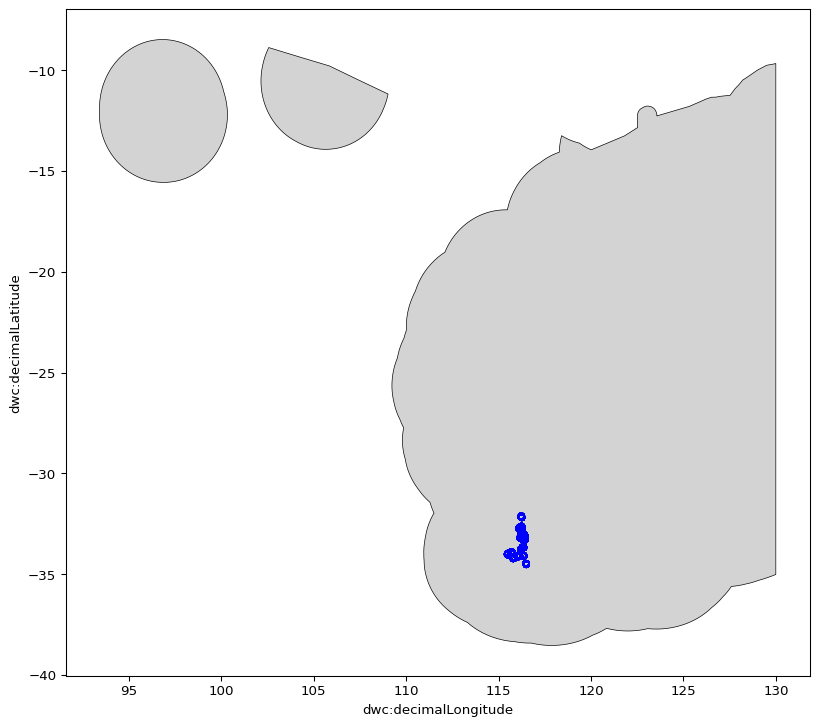

In [21]:
# visualize the coordinates.
basemap: gpd.GeoDataFrame = gpd.read_file(EEZ)
f, ax = plt.subplots(1, figsize=(10,10), dpi=96)
basemap.plot(ax=ax, color='lightgray')
extents.plot(ax=ax,cmap=None, alpha=1, edgecolor='black', color='none', linewidths=0.5)
ef.loc[lat_type_valid & lon_type_valid & loc_domain].plot.scatter(ax=ax, x='dwc:decimalLongitude', y='dwc:decimalLatitude', edgecolor='blue', color='none')
#ef.loc[lat_type_valid & lon_type_valid  & ~loc_domain].plot.scatter(ax=ax, x='dwc:decimalLongitude',y='dwc:decimalLatitude', edgecolor='red', color='none')
plt.show()

Step 9) Populate errors(bio) and status(bio):
- status(bio) is either 'valid'/'invalid' 
- errors(bio) gives reason(s) for invalidation.

In [25]:
gf: pd.DataFrame = ef.copy(deep=True)
gf['errors(bio)'] = [[] for x in range(len(gf))]
gf['status(bio)'] = float('nan')

invalid_dtype: dict[str, pd.Series] = {
    'dwc:decimalLongitude': ~lon_type_valid, # not in lon_type_valid
    'dwc:decimalLatitude': ~lat_type_valid,
    'dwc:eventDate': ~date_type_valid,
    'dwc:scientificName': ~sci_type_valid}

for column, series in invalid_dtype.items():    
    gf.loc[series, 'status(bio)'] = 'INVALID'
    message: str = f'invalid dtype in column: {column}'
    gf.loc[series, 'errors(bio)'].apply(lambda x: x.append(message))

invalid_domain: dict[str, pd.Series] = {
    'location': ~loc_domain & lon_type_valid & lat_type_valid,
    'datetime': ~date_domain & date_type_valid
    }

for domain, series in invalid_domain.items():
    message: str = f'observation outside valid {domain} domain'
    gf.loc[series, 'status(bio)'] = 'INVALID'
    gf.loc[series, 'errors(bio)'].apply(lambda x: x.append(message))

message: str = f'Record contains character with umlat.'
gf.loc[umlat, 'status(bio)'] = 'INVALID'
gf.loc[umlat, 'errors(bio)'].apply(lambda x: x.append(message))

# Set status to valid on  empty 'status(bio)' column data
m: pd.Series = gf['status(bio)'].isna()
gf.loc[m, 'status(bio)'] = 'VALID'
meta: list[str] = ['status(bio)','errors(bio)']

gf = gf.loc[:, meta+dwc+verbatim+unmapped]
gf.head()

status(bio)  \
dwc:datasetName              submission_id(bio) persistent_id(bio)               
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a         VALID   
                                                2024JRJh24e2ad37         VALID   
                                                2024JRJh24e328ae         VALID   
                                                2024JRJh24e330a3         VALID   
                                                2024JRJh24e2ce2d         VALID   

                                                                   errors(bio)  \
dwc:datasetName              submission_id(bio) persistent_id(bio)               
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a            []   
                                                2024JRJh24e2ad37            []   
                                                2024JRJh24e328ae            []   
                                                2024JRJh24e330a3            []   
                                                2024JRJh24e2ce2d            []   

                                                                    dwc:decimalLatitude  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                        
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a             -33.145531   
                                                2024JRJh24e2ad37             -34.089222   
                                                2024JRJh24e328ae             -34.120472   
                                                2024JRJh24e330a3             -34.120472   
                                                2024JRJh24e2ce2d             -34.105397   

                                                                    dwc:decimalLongitude  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                         
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a              116.237138   
                                                2024JRJh24e2ad37              116.368096   
                                                2024JRJh24e328ae              116.059745   
                                                2024JRJh24e330a3              116.059745   
                                                2024JRJh24e2ce2d              116.142347   

                                                                   dwc:eventDate  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                 
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a      2009-04-22   
                                                2024JRJh24e2ad37      2001-12-13   
                                                2024JRJh24e328ae      2001-12-11   
                                                2024JRJh24e330a3      2001-12-12   
                                                2024JRJh24e2ce2d      2001-12-11   

                                                                           dwc:scientificName  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                              
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a      Acanthophis antarcticus   
                                                2024JRJh24e2ad37    Acritoscincus trilineatus   
                                                2024JRJh24e328ae    Acritoscincus trilineatus   
                                                2024JRJh24e330a3    Acritoscincus trilineatus   
                                                2024JRJh24e2ce2d    Acritoscincus trilineatus   

                                                                   dwc:verbatimEventDate  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                         
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a              2009-04-22   
                                                2024JRJh24e2ad37              2001-12-13 

Step 10) Log summary of validation results.

In [26]:
# count invalid records.
invalid: pd.Series = (gf['status(bio)'] == 'INVALID')
invalid_count: int = len(gf.loc[invalid])

# list all reasons for invalidation, with counts.
ag: pd.DataFrame = gf.loc[invalid].copy(deep=True)
ag['errors(bio)'] = ag['errors(bio)'].apply(lambda x: str(sorted(x)))
ag: pd.DataFrame = ag.groupby(by='errors(bio)', as_index=False)['status(bio)'].count()
assert ag['status(bio)'].sum() == invalid_count

reasons: str = ag.to_string(header=False, index=False)
entry: str = f'{invalid_count} out of {len(gf)} records marked as invalid, reasons: {reasons}.'
logevent(description=entry, user=socket.gethostname(), eventlog=eventlog)

,event_id,datetime,user,description
0,2024JRJcI5329b02,2024-09-17T09:28:08.340655,Charles,"errors when reading file ""AquaticProjects/ForestCheck Data/Vertebrates/Vertebrates Master File.xlsx"" : N/A"
1,2024JRJhs91657a8,2024-09-17T09:33:44.595570,Charles,"""AquaticProjects/ForestCheck Data/Vertebrates/Vertebrates Master File.xlsx"" in container ""015-extracted-data"" tagged with: {'submission_id': '2024JRJhs7ad2213', 'dataset': 'Vertebrates Master File data'}"
2,2024JRJh25182f96,2024-09-17T09:33:53.333896,Charles,"4073 uids added to column ""persistent_id(bio)""."
3,2024JRJjF6ace10b,2024-09-17T09:35:05.437494,Charles,"columns ""dwc:datasetName"" and ""submission_id(bio)"" populated."
4,2024JRJjM25b5a61,2024-09-17T09:35:12.154478,Charles,"columns remapped: {'SCIENTIFIC NAME': 'dwc:scientificName', 'DATE': 'dwc:eventDate', 'Latitude': 'dwc:decimalLatitude', 'Longitude': 'dwc:decimalLongitude'}"
5,2024JRJjM262f634,2024-09-17T09:35:12.156423,Charles,"verbatim fields added: {'SCIENTIFIC NAME': 'dwc:verbatimIdentification', 'DATE': 'dwc:verbatimEventDate', 'Latitude': 'dwc:verbatimLatitude', 'Longitude': 'dwc:verbatimLongitude'}"
6,2024JRJkD73d5db3,2024-09-17T09:36:03.474485,Charles,number of missing string values replaced: 0.
7,2024JRNeK0c6fb2f,2024-09-17T13:30:10.050961,Charles,"515 out of 4073 records marked as invalid, reasons: ['invalid dtype in column: dwc:scientificName'] 515."


Step 11) write to 025-preprocessed-data.  

In [27]:
write_to_blob(gf, a25_preprocessed, targetp, index=True, timeout=12000)
tagfile(a25_preprocessed, targetp, tags)

{'submission_id': '2024JRJhs7ad2213',
 'dataset': 'Vertebrates Master File data'}

Step 12) write log to 030-ingestion-ready

In [28]:
# write log to blob.
write_to_blob(eventlog, a30_ingestion, logpath, index=False, timeout=12000)
tagfile(a30_ingestion, logpath, tags)

{'submission_id': '2024JRJhs7ad2213',
 'dataset': 'Vertebrates Master File data'}

Step 13) Separate valid/invalid records.

In [31]:
# isolate invalid records, write to predefined location.
v: pd.Series = (gf['status(bio)'] == 'VALID')
inval: pd.DataFrame = gf.loc[~v]
valid: pd.DataFrame = gf.loc[v]


Step 14a) Write invalid records to 030-ingestion-ready

In [32]:
write_to_blob(inval, a30_ingestion, invpath, index=True, timeout=12000)
tagfile(a30_ingestion, invpath, tags)

{'submission_id': '2024JRJhs7ad2213',
 'dataset': 'Vertebrates Master File data'}

Step 14b) Partition valid records on attribute or by record limit.

In [34]:
hf: pd.DataFrame = valid.copy(deep=True)
RECORDLIMIT: int = 10000
PARTCOLUMNS: list[str] = []

if (len(hf) > 0): # Checking that hf dataframe isn't empty
    hf['part(bio)'] = float('nan')
    if len(PARTCOLUMNS) > 0: # If PARTCOLUMNS isn't empty
        hf['filename(bio)'] = hf.apply(lambda x: f'{partdir}/{filename}_{combine_str(x[PARTCOLUMNS]).lower()}_', axis=1)
    else: # if its empty
        hf['filename(bio)'] = hf.apply(lambda x: f'{partdir}/{filename}_', axis=1)
    hf.sort_values(by='filename(bio)', inplace=True)
    
    # limit the rows in each segment.
    for filename1 in hf['filename(bio)'].unique():
        m: pd.Series = (hf['filename(bio)'] == filename1)
        hf.loc[m, 'part(bio)'] = row_limit(len(hf.loc[m]), RECORDLIMIT) # Limit the number of rows for each unique record to 10,000 (according to the set RECORDLIMIT), and assign a part number to part(bio)
    hf['filename(bio)'] = hf.apply(lambda x: f"{x['filename(bio)']}{x['part(bio)']}.csv", axis=1) # Generate the filename by appending filename part number and .csv extension
    hf.drop(columns='part(bio)', inplace=True) # Drop the part number (part(bio)) column

hf.head()

status(bio)  \
dwc:datasetName              submission_id(bio) persistent_id(bio)               
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a         VALID   
                                                2024JRJh24f52445         VALID   
                                                2024JRJh24f51b4f         VALID   
                                                2024JRJh24f50fdc         VALID   
                                                2024JRJh24f50dee         VALID   

                                                                   errors(bio)  \
dwc:datasetName              submission_id(bio) persistent_id(bio)               
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a            []   
                                                2024JRJh24f52445            []   
                                                2024JRJh24f51b4f            []   
                                                2024JRJh24f50fdc            []   
                                                2024JRJh24f50dee            []   

                                                                    dwc:decimalLatitude  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                        
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a             -33.145531   
                                                2024JRJh24f52445             -33.149898   
                                                2024JRJh24f51b4f             -33.149898   
                                                2024JRJh24f50fdc             -33.145531   
                                                2024JRJh24f50dee             -33.145531   

                                                                    dwc:decimalLongitude  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                         
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a              116.237138   
                                                2024JRJh24f52445              116.240235   
                                                2024JRJh24f51b4f              116.240235   
                                                2024JRJh24f50fdc              116.237138   
                                                2024JRJh24f50dee              116.237138   

                                                                   dwc:eventDate  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                 
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a      2009-04-22   
                                                2024JRJh24f52445      2009-04-18   
                                                2024JRJh24f51b4f      2009-04-16   
                                                2024JRJh24f50fdc      2009-04-21   
                                                2024JRJh24f50dee      2009-04-20   

                                                                         dwc:scientificName  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                            
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a    Acanthophis antarcticus   
                                                2024JRJh24f52445              Rattus rattus   
                                                2024JRJh24f51b4f              Rattus rattus   
                                                2024JRJh24f50fdc              Rattus rattus   
                                                2024JRJh24f50dee              Rattus rattus   

                                                                   dwc:verbatimEventDate  \
dwc:datasetName              submission_id(bio) persistent_id(bio)                         
Vertebrates Master File data 2024JRJhs7ad2213   2024JRJh24f5165a              2009-04-22   
                                                2024JRJh24f52445              2009-04-18   
           

Step 15) Write parts as csv file to 030-ingestion-ready

In [36]:
jf: pd.DataFrame = hf.copy(deep=True)
if (len(jf) > 0): # Checking that jf dataframe isn't empty
    for mypath in jf['filename(bio)'].unique():
        m: pd.Series = (jf['filename(bio)'] == mypath)
        segment: pd.DataFrame = jf.loc[m].drop(columns='filename(bio)')
        write_to_blob(segment, a30_ingestion, Path(mypath), index=True, timeout=12000)
        tagfile(a30_ingestion, Path(mypath), tags)